In [7]:
import os
import shutil
import glob
import SimpleITK as sitk
import six
import radiomics
import getopt
import sys
from pydicom import dcmread
import dicom2nifti
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from radiomics import featureextractor, getTestCase
import pydicom
import pydicom_seg
import SimpleITK as sitk
import ast
import json
import pandas
import seaborn as sns
from operator import itemgetter
# importing the zipfile module
from zipfile import ZipFile
BASE_PATH = "/data4/hrehman/Clinical_Data/"

# BASE_PATH_zipped = "/data/radiogenomics/data/NSCLC_Radiogenomics/raw/"
# INPUT_FOLDER = 'data4/Clinical Data/3-13-2023/'
INPUT_FOLDER = BASE_PATH + '3-13-2023/'
# INPUT_FOLDER_zipped = BASE_PATH_zipped
# patients_zipped = os.listdir(INPUT_FOLDER_zipped)
# patients_zipped.sort()
segmentaion_dict = {}

Comparison of brain test images from github with the data we have and see if everything is ok

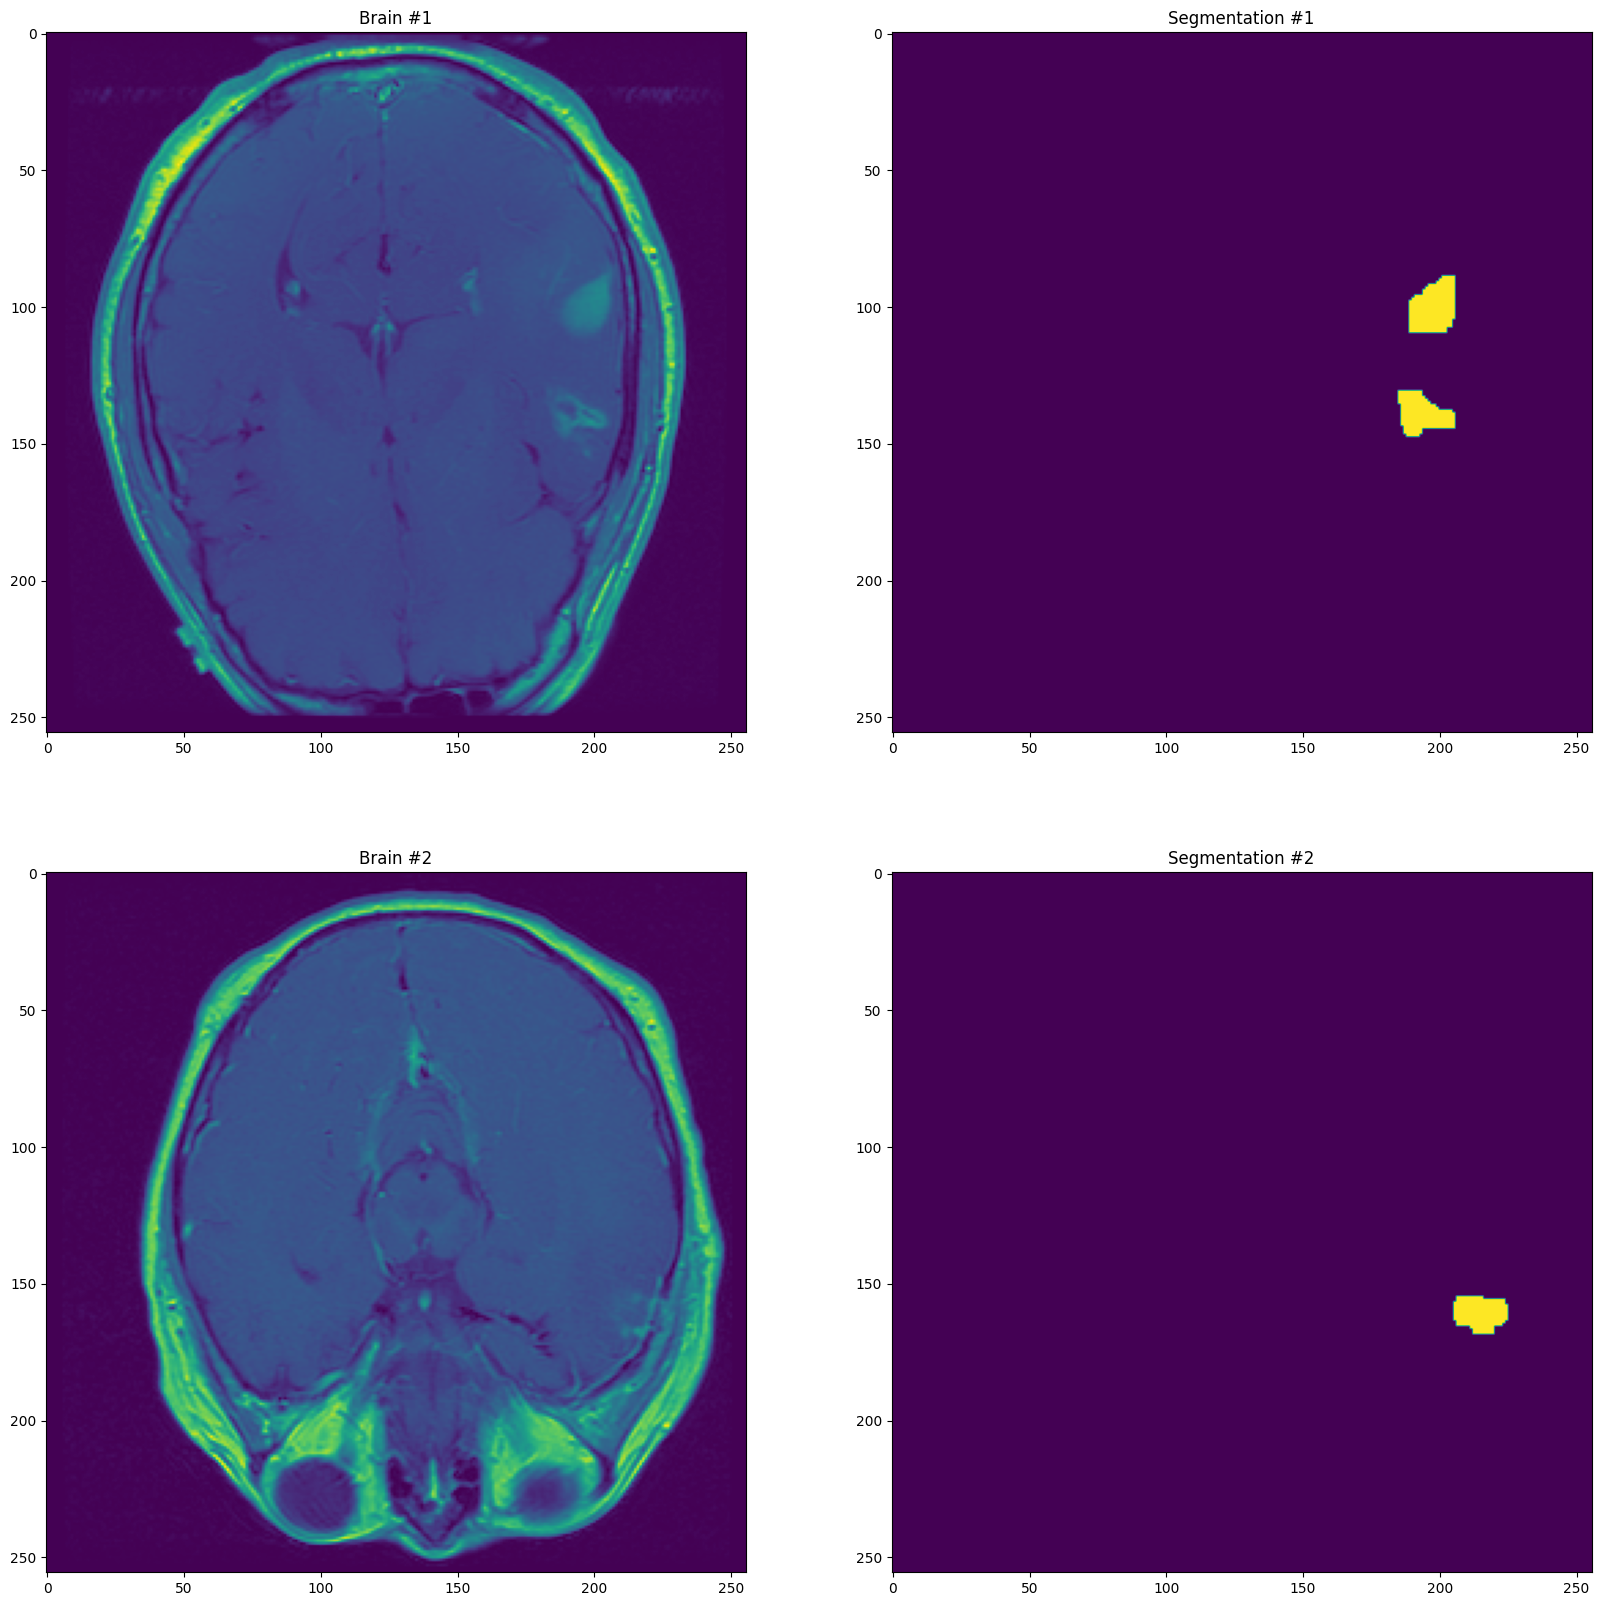

In [2]:
import os
import SimpleITK as sitk

from radiomics import getTestCase

imagepath_1, labelpath_1 = getTestCase('brain1')
imagepath_2, labelpath_2 = getTestCase('brain2')

image_1 = sitk.ReadImage(imagepath_1)
label_1 = sitk.ReadImage(labelpath_1)
image_2 = sitk.ReadImage(imagepath_2)
label_2 = sitk.ReadImage(labelpath_2)
# Display the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[12,:,:])
plt.title("Brain #1")
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[12,:,:])        
plt.title("Segmentation #1")

# Second image
plt.subplot(2,2,3)
plt.imshow(sitk.GetArrayFromImage(image_2)[8,:,:])        
plt.title("Brain #2")

plt.subplot(2,2,4)
plt.imshow(sitk.GetArrayFromImage(label_2)[8,:,:])        
plt.title("Segmentation #2")

plt.show()

Here we will unzip the data of all tghe patients to another folder and once the dicoms are extracted, we will convert to Nifti and delete the original one

In [3]:
def unzipping_segFiles():
    for patient in patients_zipped:
        zipped_folder = os.listdir(BASE_PATH_zipped + patient + "/SEG/")[0]
        with ZipFile(BASE_PATH_zipped + patient + "/SEG/" + zipped_folder, 'r') as zip:
            # printing all the contents of the zip file
            # extracting all the files
            print('Extracting all the files now...')
            zip.extractall(INPUT_FOLDER + patient + "/SEG/")
            print('Done!')
def unzipping_ctFiles():
    for patient in patients_zipped:
        zipped_folder = os.listdir(BASE_PATH_zipped + patient + "/CT/")[0]
        with ZipFile(BASE_PATH_zipped + patient + "/CT/" + zipped_folder, 'r') as zip:
            # printing all the contents of the zip file
            # extracting all the files
            print('Extracting all the files now...')
            zip.extractall(INPUT_FOLDER + patient + "/CT/")
            print('Done!')
#Uncommets these lines if you have to unzip the dicoms
# unzipping_segFiles()
# unzipping_ctFiles()

#Once all the files are unzipped into a new location , we will read all the patinets
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [4]:
len(patients)

137

In [69]:
# These are all those patients who have missing segmentations 
# patients = ["R01-020","R01-049","R01-052","R01-056","R01-075","R01-090","R01-098","R01-026","R01-044","R01-048","R01-078"]

In [5]:
def last_4chars(x):
    return(x[-1:])

def sort_dcm_files_CT(patient):
    folder = os.listdir(INPUT_FOLDER + patient + '/CT/')
    path = INPUT_FOLDER + patient + '/CT/'
    list_of_files = os.listdir(path)
    # for specific cases like the patinets in the above cell you can see they have different file formate, in order to fix this we have to perform sorting on the second part of the filename
    # this line is for sorting on first part of the -
    list_of_files = sorted(list_of_files, key=lambda x: int(x.split("-")[0]))
    # this line is for sorting on second part of the - for the patinets that are above mentioned
    # list_of_files = sorted(list_of_files, key=lambda x: int(str(x.split("-")[1]).split(".")[0]))
    return list_of_files
def get_SEG(patient):
    folder = os.listdir(INPUT_FOLDER + patient + '/SEG')
    path = INPUT_FOLDER + patient + '/SEG/'
    file = os.listdir(path)
    return file

def get_reference_segmnetation(ds):
    reference_CT = ds[0x0008, 0x1115][0][0x0008, 0x114a]
    return reference_CT

In the follwing chuck we are reading each dicom file , find the corresponding segmentation of each dicom , and then create a json format file which saves the key as CT scan number and the value as the position of segmentation from all the stacked slices of a lung.
it took 7 minutes for the conversion

In [9]:
def create_config():
        for patient in patients:
            print(patient)

            ## Get the CT scan first and create a sorted list with all the information
            CT_info = []
            CT_files = []
            path = INPUT_FOLDER + patient + '/CT/'
            files = sort_dcm_files_CT(patient=patient)
            for file in files:
                CT_files.append(dcmread(os.path.join(path,file)))
            for slice in CT_files:
                CT = {"UID" : None,
                    "file" : None,
                    "Location": None,
                    "pixels" : None}
                CT['UID'] =  slice[0x0008, 0x0018].value
                CT['Location'] =  slice[0x0020, 0x1041].value
                CT['pixels'] =  slice.pixel_array
                CT_info.append(CT)
            CT_info = sorted(CT_info, key=itemgetter('Location'))
            
            ## Now we will get the segmentation:
            segmentaion_dict = {}
            seg_ids = []
            #get a patient segmentation
            file = os.listdir(INPUT_FOLDER + patient + '/SEG')
            path = INPUT_FOLDER + patient + '/SEG/'

            #Read the segmentation and get the reference CT of it
            SEG = dcmread(os.path.join(path,file[0]))
            SEG_pixel_array = SEG.pixel_array
            segmentations = get_reference_segmnetation(SEG)
            new_image_data = np.zeros((512,512,len(files)),dtype="int16")
            #populate the dictionary with the values of segmentation as 0,1,2 ....
            for i,seg in enumerate(segmentations):
                        seg_ids.append(str(seg[0x0008, 0x1155].value))
                        segmentaion_dict[i] = ''

            for i,ct_item in  enumerate(CT_info):
                if str(ct_item['UID']) in seg_ids:
                    for j,v in enumerate(seg_ids):
                                # print(j,v)
                                if v == str(ct_item['UID']):
                                    # for all the patinets 
                                    # where J is the position of segmentation in segmentation file and i is the corresponding to the CT scan position
                                    segmentaion_dict[j] = i
            print(segmentaion_dict)
            with open( BASE_PATH + "Nifti/config/" + patient + ".txt", 'w') as f: 
                # for key, value in segmentaion_dict.items(): 
                #     f.write('%s:%s\n' % (key, value))
                json.dump(segmentaion_dict,f)

In [54]:
'''This function will basically create a corresponding file of each mask location(key) , to the actual location according to the CT scans (value)'''
create_config() 

R01-001
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 1

convert dicom files to Nifti first for CT scans

In [12]:
# config_patinets = ["R01-020.txt","R01-049.txt","R01-052.txt","R01-056.txt","R01-075.txt","R01-090.txt","R01-098.txt"]
config_patinets = os.listdir(BASE_PATH + "Nifti/config")
len(config_patinets)

137

In [13]:
def convertCTFiles():
    count = 0
    for patient in patients:
        if str(patient+'.txt') in config_patinets:
            print(patient)
            path = BASE_PATH + "Nifti/" + patient + '/CT/'
            # folder = os.listdir(INPUT_FOLDER + patient + '/CT/')
            if os.path.exists(path=path) == False:
                os.makedirs(path)
            # dicom2nifti.convert_directory(INPUT_FOLDER + patient + '/CT' + folder[0],path,sorter=last_4chars)
            files = sort_dcm_files_CT(patient=patient)
            dicom_list = [pydicom.read_file(os.path.join(INPUT_FOLDER + patient + '/CT/', f)) for f in files]
            dicom2nifti.convert_dicom.dicom_array_to_nifti(dicom_list,os.path.join(path, 'output.nii'),reorient_nifti=False)
            # dicom2nifti.dicom_series_to_nifti(dicom_list,os.path.join(path, 'output.nii.gz'),reorient_nifti=False)

convert dicom files to Nifti of Segmentaion

In [14]:
def convertSEGFiles():
    for patient in patients:
        if str(patient+'.txt') in config_patinets:
            print(patient)
            path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
            folder = os.listdir(INPUT_FOLDER + patient + '/SEG')
            if os.path.exists(path=path) == False:
                os.makedirs(path)
            file = os.listdir(INPUT_FOLDER + patient + '/SEG/')
            dcm = pydicom.dcmread(INPUT_FOLDER + patient + '/SEG/'+file[0])
            reader = pydicom_seg.SegmentReader()
            result = reader.read(dcm)
            # print(result.available_segments)
            for segment_number in result.available_segments:
                image_data = result.segment_data(segment_number)  # directly available
                image = result.segment_image(segment_number)  # lazy construction
                sitk.WriteImage(image, str(path) + str(segment_number) + ".nii")

In [15]:
#It took 11 minutes to run the whole thing
convertCTFiles()

R01-001
R01-002
R01-003
R01-004
R01-005
R01-006
R01-007
R01-008
R01-010
R01-011
R01-012
R01-013
R01-015
R01-016
R01-017
R01-018
R01-019
R01-020
R01-021
R01-022
R01-023
R01-024
R01-025
R01-026
R01-027
R01-028
R01-029
R01-030
R01-031
R01-032
R01-033
R01-034
R01-035
R01-036
R01-037
R01-038
R01-039
R01-040
R01-041
R01-042
R01-043
R01-044
R01-045
R01-046
R01-047
R01-048
R01-049
R01-050
R01-051
R01-052
R01-053
R01-054
R01-055
R01-056
R01-057
R01-058
R01-060
R01-061
R01-062
R01-063
R01-064
R01-065
R01-066
R01-067
R01-068
R01-069
R01-070
R01-071
R01-072
R01-073
R01-074
R01-075
R01-076
R01-077
R01-078
R01-079
R01-080
R01-081
R01-082
R01-083
R01-084
R01-085
R01-086
R01-087
R01-088
R01-089
R01-090
R01-091
R01-092
R01-093
R01-094
R01-095
R01-096
R01-097
R01-098
R01-099
R01-100
R01-101
R01-102
R01-103
R01-104
R01-105
R01-106
R01-107
R01-108
R01-109
R01-110
R01-111
R01-112
R01-113
R01-115
R01-117
R01-118
R01-122
R01-123
R01-124
R01-125
R01-126
R01-127
R01-128
R01-129
R01-130
R01-131
R01-132
R01-133


In [16]:
convertSEGFiles()

R01-001
R01-002
R01-003
R01-004
R01-005
R01-006
R01-007
R01-008
R01-010
R01-011
R01-012
R01-013
R01-015
R01-016
R01-017
R01-018
R01-019
R01-020
R01-021
R01-022
R01-023
R01-024
R01-025
R01-026
R01-027
R01-028


R01-029
R01-030
R01-031
R01-032
R01-033
R01-034
R01-035
R01-036
R01-037
R01-038
R01-039
R01-040
R01-041
R01-042
R01-043
R01-044
R01-045
R01-046
R01-047
R01-048
R01-049
R01-050
R01-051
R01-052
R01-053
R01-054
R01-055
R01-056
R01-057
R01-058
R01-060
R01-061
R01-062
R01-063
R01-064
R01-065
R01-066
R01-067
R01-068
R01-069
R01-070
R01-071
R01-072
R01-073
R01-074
R01-075
R01-076
R01-077
R01-078
R01-079
R01-080
R01-081
R01-082
R01-083
R01-084
R01-085
R01-086
R01-087
R01-088
R01-089
R01-090
R01-091
R01-092
R01-093
R01-094
R01-095
R01-096
R01-097
R01-098
R01-099
R01-100
R01-101
R01-102
R01-103
R01-104
R01-105
R01-106
R01-107
R01-108
R01-109
R01-110
R01-111
R01-112
R01-113
R01-115
R01-117
R01-118
R01-122
R01-123
R01-124
R01-125
R01-126
R01-127
R01-128
R01-129
R01-130
R01-131
R01-132
R01-133
R01-134
R01-135
R01-136
R01-137
R01-138
R01-139
R01-140
R01-141
R01-142
R01-144
R01-145
R01-146


In [18]:
# #Delete all the unzipped dicom files since they are occupying the space for not reason
# # os.remove(r"/data4/hrehman/Clinical Data/3-13-2023")
# import shutil
# shutil.rmtree("/data4/hrehman/Clinical_Data/3-13-2023/")

Here im just checking if the dicom files also have same issues with the segmentation

In [20]:
# reading the data from the file
with open(BASE_PATH + 'Nifti/config/R01-001.txt',"r") as f:
   config =  json.load(f)
CT = sitk.ReadImage( BASE_PATH +"/Nifti/R01-001/CT/output.nii")
CT = sitk.GetArrayFromImage(CT)
SEG = sitk.ReadImage(BASE_PATH + "/Nifti/R01-001/SEG/1.nii")
SEG = sitk.GetArrayFromImage(SEG)
config.get("0") #this says that the first Segmentaion has original CT on 5
sampleCT = CT[config.get("12"),:,:]
sampleSeg = SEG[12,:,:]


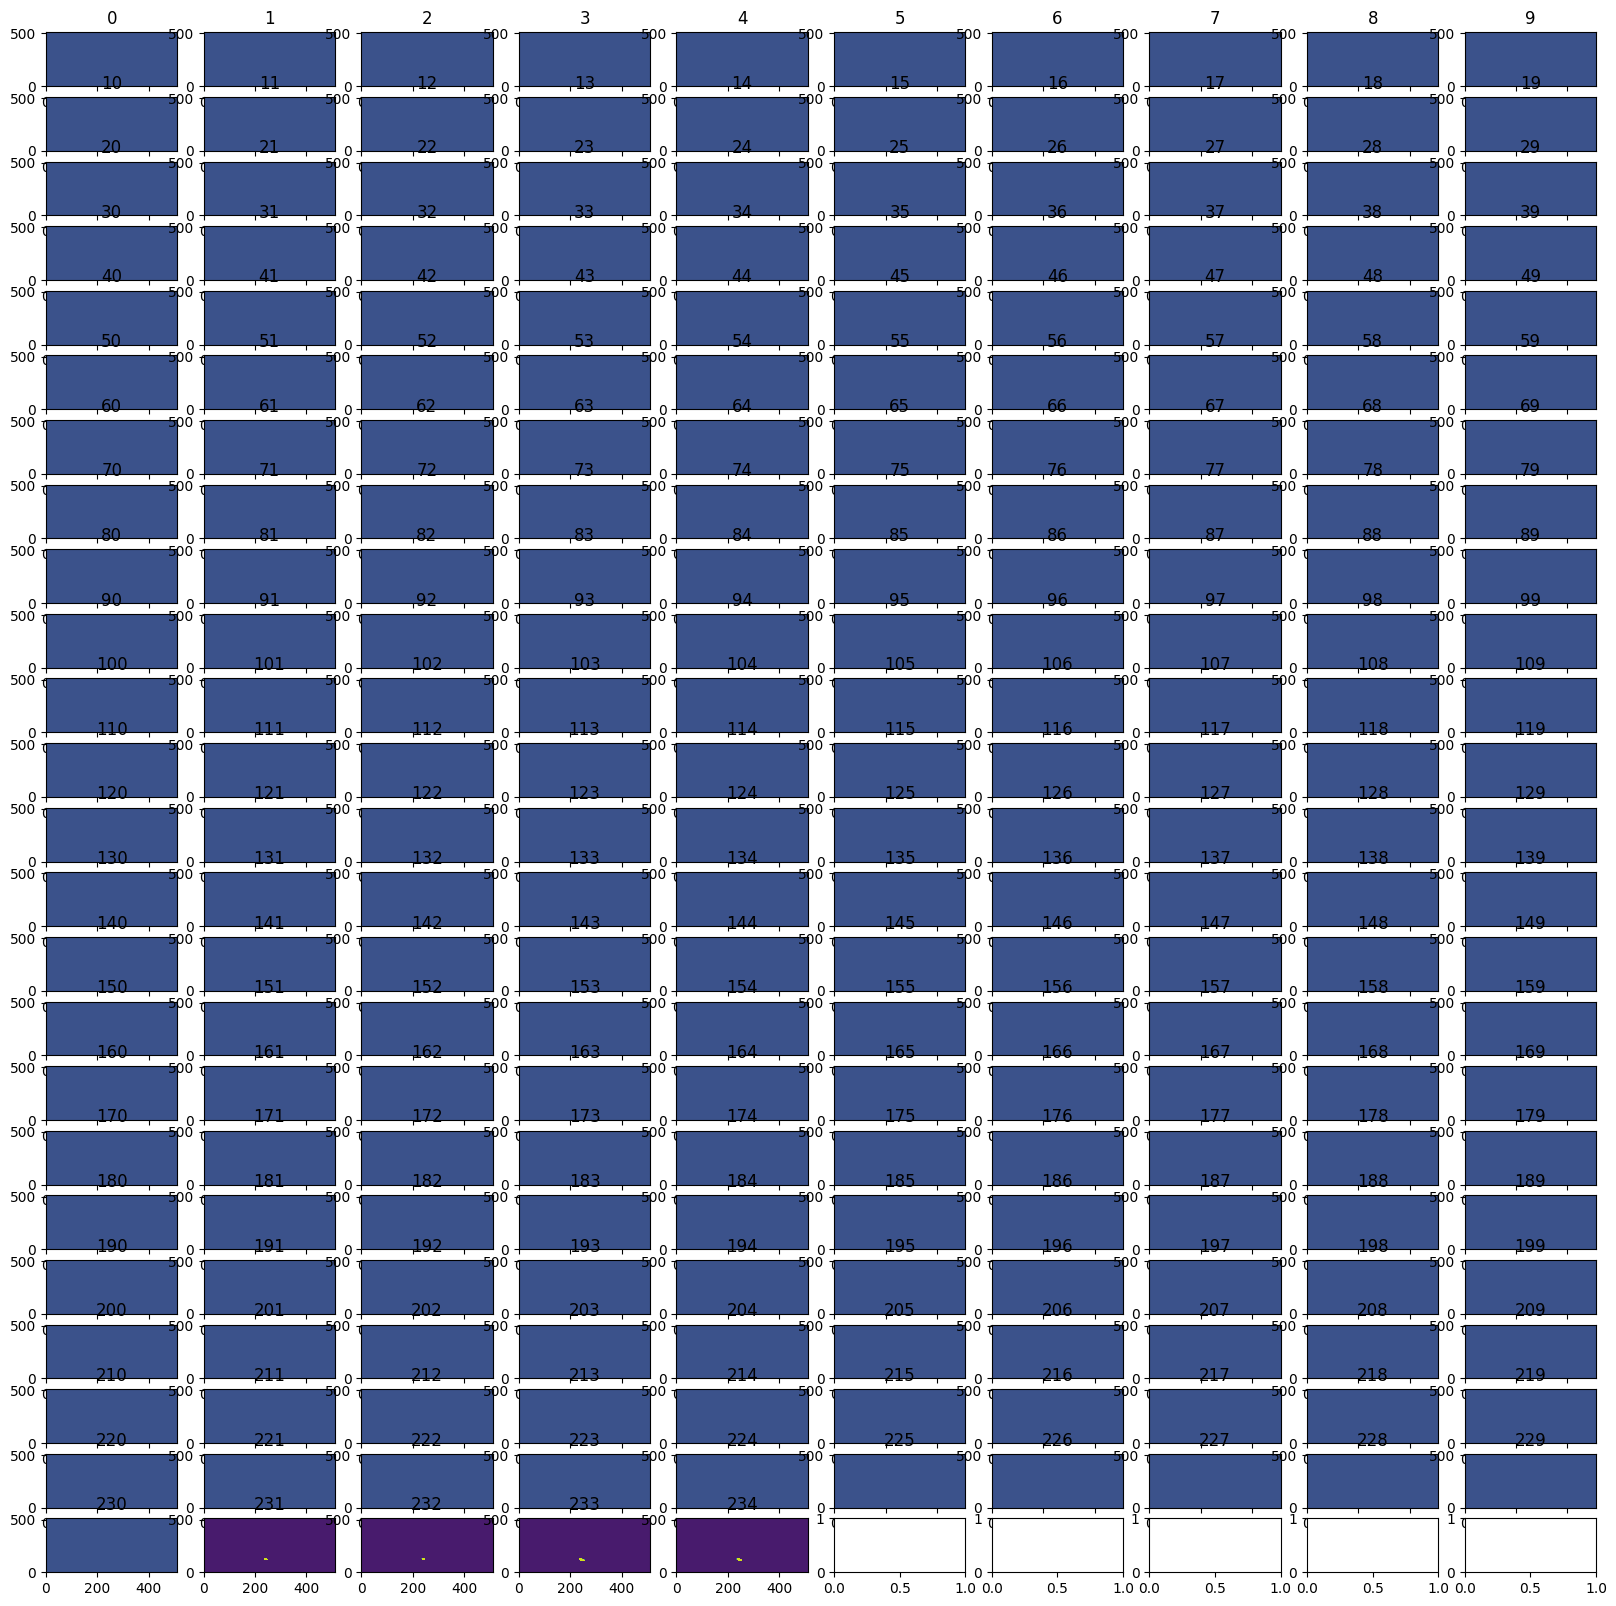

In [37]:
test_load = nib.load("/data4/hrehman/Clinical_Data/Nifti/R01-001/SEG/1.nii").get_fdata()
test_load.shape
fig, axs = plt.subplots(24,10, figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
# plt.imshow(test_load[:,:,141],cmap='gray')
axs = axs.ravel()

for i in range(235):
    # axs[i].contourf(test_load[:,:,i])
    axs[i].contourf(test_load[:,:,i])
    axs[i].set_title(i)

IndexError: index 20 is out of bounds for axis 2 with size 20

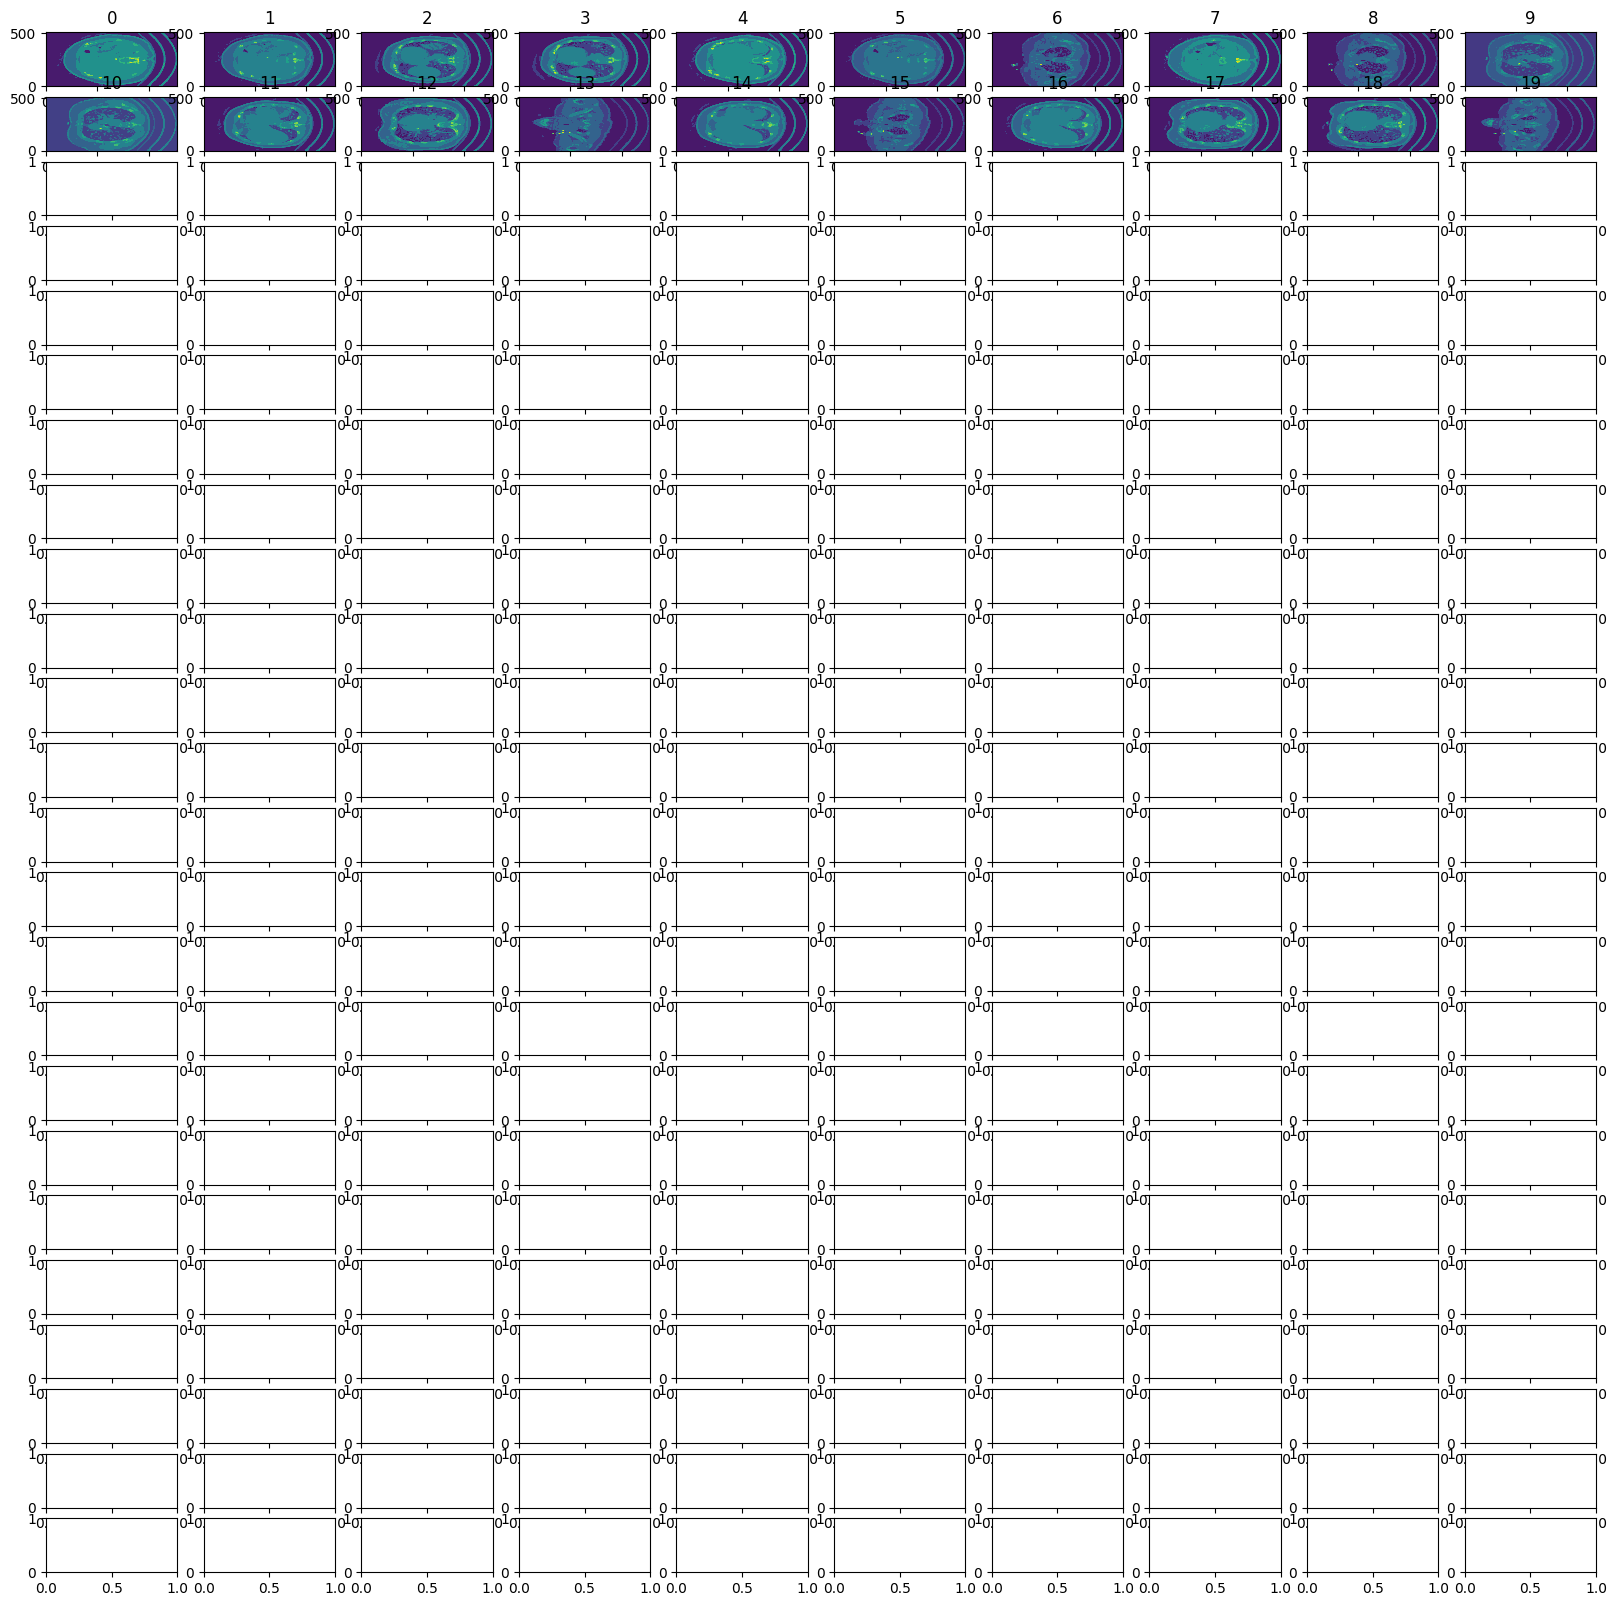

In [44]:
test_load = nib.load("/data4/hrehman/Clinical_Data/Nifti/R01-001/CT/output_clean.nii").get_fdata()
test_load.shape
fig, axs = plt.subplots(24,10, figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
# plt.imshow(test_load[:,:,141],cmap='gray')
axs = axs.ravel()

for i in range(235):
    # axs[i].contourf(test_load[:,:,i])
    axs[i].contourf(test_load[:,:,i])
    axs[i].set_title(i)

In [39]:
def mask_conversion():
                count = 0 
                # config_patinets = ["R01-020.txt","R01-049.txt","R01-052.txt","R01-056.txt","R01-075.txt","R01-090.txt","R01-098.txt"]
                config_patinets = os.listdir(BASE_PATH + "Nifti/config")
                len(config_patinets)
                for patient in patients:
                    print(patient)
                    count+=1
                    if str(patient+'.txt') in config_patinets:
                        path = BASE_PATH + "Nifti/" + patient
                        # Load the original NIfTI file
                        nii_file = nib.load(path  + '/SEG/'+ "1.nii")
                        CT_file = nib.load(path + '/CT/'+ "output.nii")

                        # Get the image data as a Numpy array
                        mask_data = nii_file.get_fdata()
                        
                        # reading the data from the file
                        with open(BASE_PATH + 'Nifti/config(full)/'+patient+'.txt',"r") as f:
                            config =  json.load(f)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
                        # Define the dictionary that specifies the slice order
                        slice_order = config
                        
                        # Create a new Numpy array to hold the reordered slices
                        # new_image_data = np.zeros((512,512,len(config)),dtype="int16")
                        new_mask_data = np.zeros(CT_file.shape,dtype="int16")

                        # Loop through the dictionary and copy each slice to its new position
                        for old_idx, new_idx in slice_order.items():
                            new_idx = int(new_idx)
                            old_idx = int(old_idx)
                            new_mask_data[:, :, new_idx] = mask_data[:, :, old_idx]

                        # Create a new NIfTI file with the reordered slices
                        new_nii_file = nib.Nifti1Image(new_mask_data, nii_file.affine, header=nii_file.header)
                        path = BASE_PATH + "/Nifti/"+patient+"/SEG/"
                        name = patient
                        # Save the new NIfTI file
                        nib.save(new_nii_file, path + name + ".nii")
                print(count , "Patients CT data was cleaned with relavent segmentations")
                

In [40]:
mask_conversion()

R01-001
R01-002
R01-003
R01-004
R01-005
R01-006
R01-007
R01-008
R01-010
R01-011
R01-012
R01-013
R01-015
R01-016
R01-017
R01-018
R01-019
R01-020
R01-021
R01-022
R01-023
R01-024
R01-025
R01-026
R01-027
R01-028
R01-029
R01-030
R01-031
R01-032
R01-033
R01-034
R01-035
R01-036
R01-037
R01-038
R01-039
R01-040
R01-041
R01-042
R01-043
R01-044
R01-045
R01-046
R01-047
R01-048
R01-049
R01-050
R01-051
R01-052
R01-053
R01-054
R01-055
R01-056
R01-057
R01-058
R01-060
R01-061
R01-062
R01-063
R01-064
R01-065
R01-066
R01-067
R01-068
R01-069
R01-070
R01-071
R01-072
R01-073
R01-074
R01-075
R01-076
R01-077
R01-078
R01-079
R01-080
R01-081
R01-082
R01-083
R01-084
R01-085
R01-086
R01-087
R01-088
R01-089
R01-090
R01-091
R01-092
R01-093
R01-094
R01-095
R01-096
R01-097
R01-098
R01-099
R01-100
R01-101
R01-102
R01-103
R01-104
R01-105
R01-106
R01-107
R01-108
R01-109
R01-110
R01-111
R01-112
R01-113
R01-115
R01-117
R01-118
R01-122
R01-123
R01-124
R01-125
R01-126
R01-127
R01-128
R01-129
R01-130
R01-131
R01-132
R01-133


IndexError: index 233 is out of bounds for axis 2 with size 233

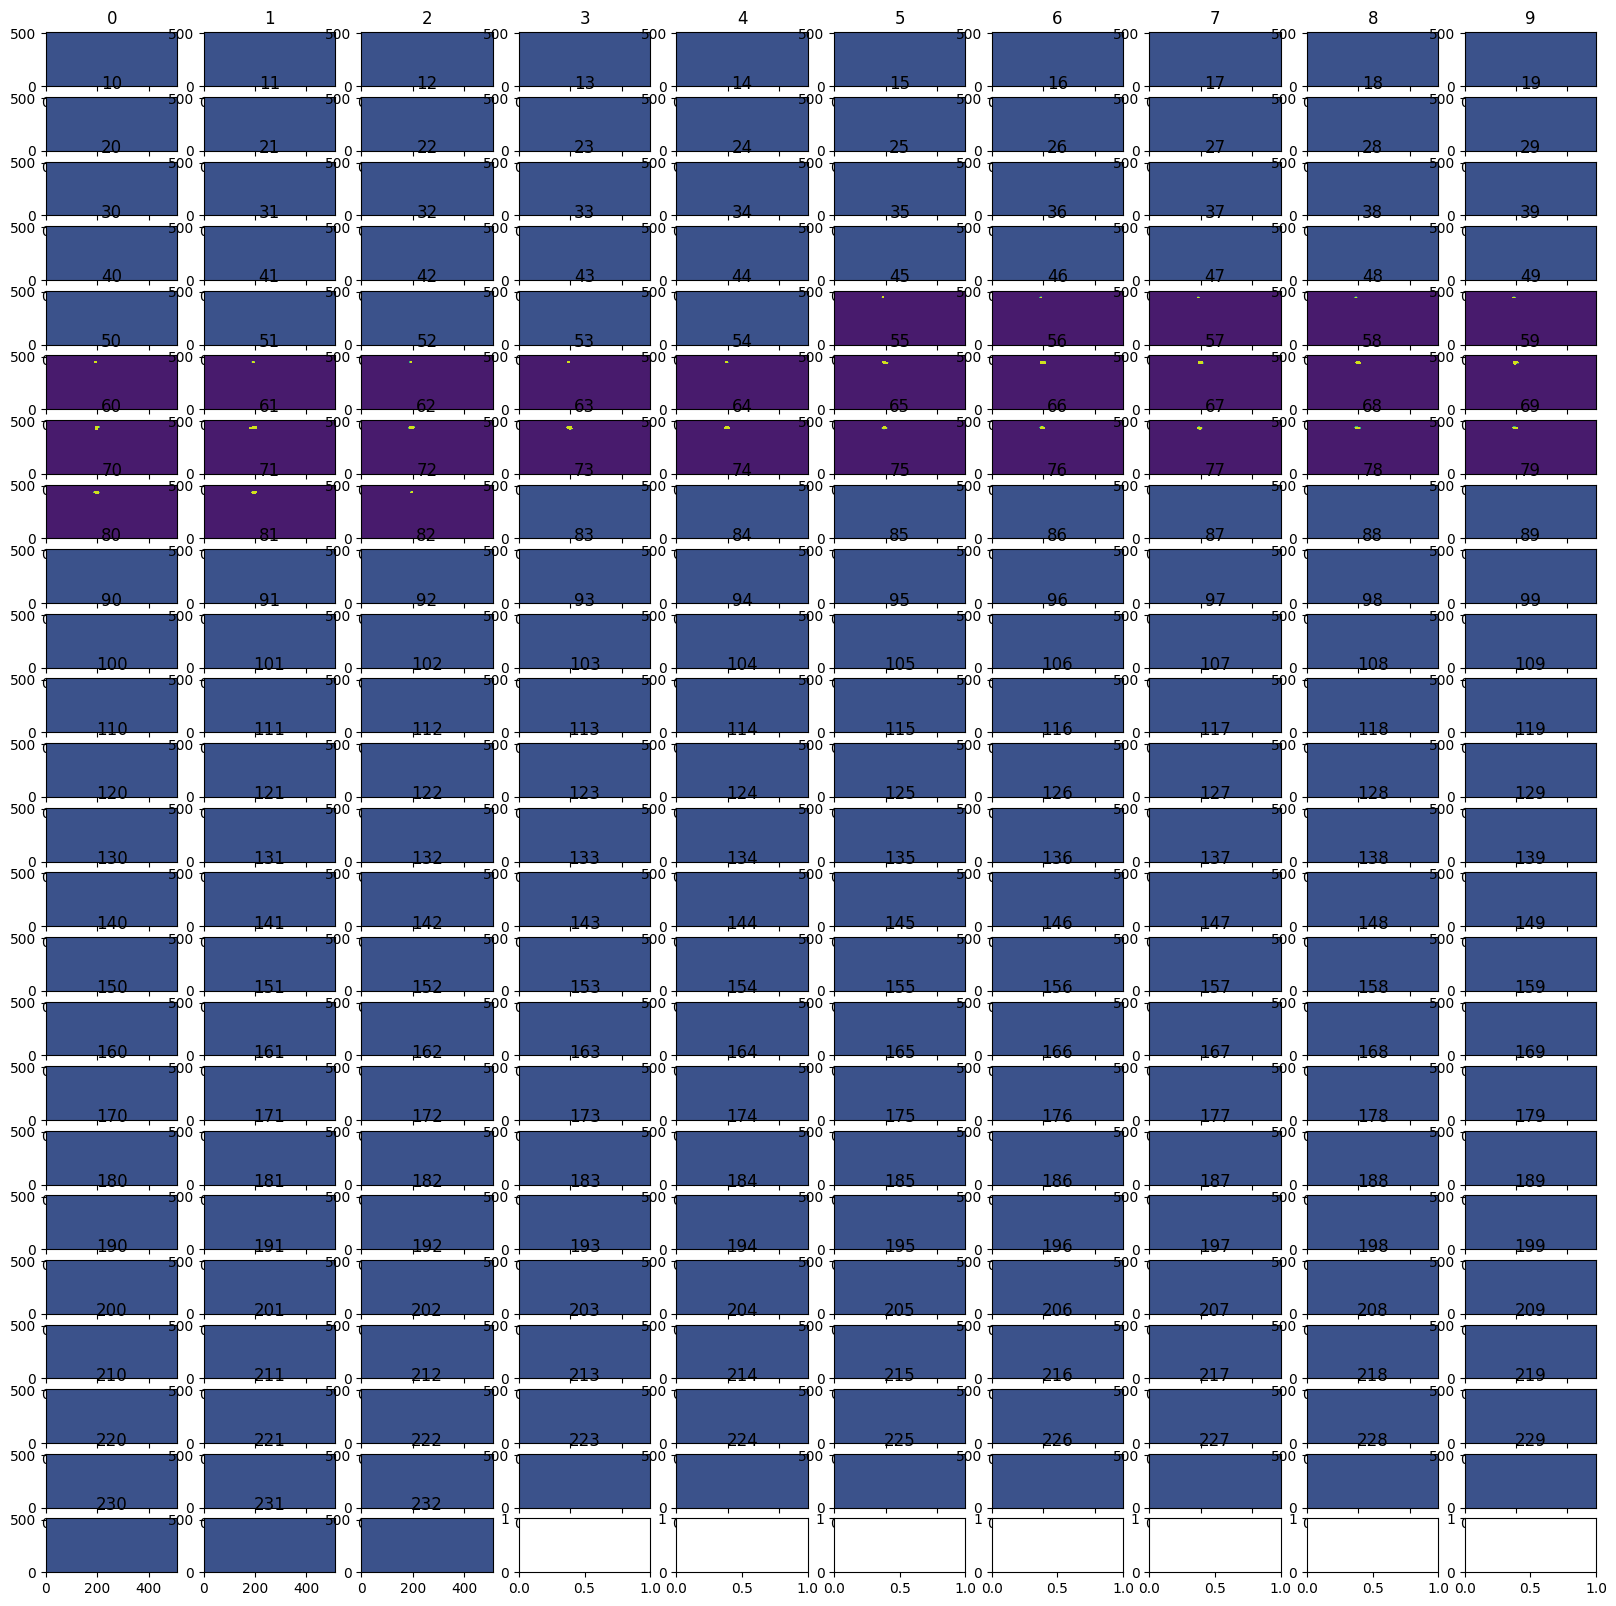

In [42]:
test_load = nib.load("/data4/hrehman/Clinical_Data/Nifti/R01-110/SEG/R01-110.nii").get_fdata()
test_load.shape
fig, axs = plt.subplots(24,10, figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
# plt.imshow(test_load[:,:,141],cmap='gray')
axs = axs.ravel()

for i in range(235):
    # axs[i].contourf(test_load[:,:,i])
    axs[i].contourf(test_load[:,:,i])
    axs[i].set_title(i)

In [45]:
def findStart(SEG):
    start = True
    count = len(SEG)
    startval = 0
    i = 0
    #Running Array into the forward direction to find start of segmentation set
    for img in SEG:
        if(i == count):
            break
        else:
            countzero = np.count_nonzero(img)
            if countzero !=0 and start==True:
                start = False
                startval = i
                break
        i+=1
    return startval
def findEnd(SEG):
    end = True
    #Running Array into the backwards direction to find end of segmentation set
    i = len(SEG) -1
    count = 0
    endval = 0
    # SEG_rev = SEG[:, :, ::-1]
    SEG_rev  =np.flip(SEG, axis=None)
    # print(SEG_rev)
    for img in SEG_rev:
        if(i == count):
            break
        else:
            countzero = np.count_nonzero(img)
            if countzero !=0 and end==True:
                end = False
                endval = i
                break
        i-=1
    return endval

In [68]:
import os
os.path
for patient in patients:
            if str(patient+'.txt') in config_patinets:
                path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
                if os.path.exists(path +patient +"clean.nii"):
                    os.remove(path +patient +"clean.nii")

In [86]:
#detele the segmentation with all values as zero
# reading the data from the file
def clean_CT_Seg():
        for patient in patients:
            if str(patient+'.txt') in config_patinets:
                print(patient)
                with open(BASE_PATH + 'Nifti/config/'+patient+'.txt',"r") as f:
                    config =  json.load(f)
                    # print(len(config))
                path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
                Segmentations = sitk.ReadImage(path + patient+".nii")
                
                SEG = sitk.GetArrayFromImage(Segmentations)
                new_pixel_array = []
                
                #find start and end of the segmentation slices
                (start) = findStart(SEG)
                (end) = findEnd(SEG)

                ##Editing the configuration files
                i = 0
                count = len(SEG)
                for img in SEG:
                    if start <= i and end >= i:
                        new_pixel_array.append(img)
                    i+=1
                path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
                # if this is supposed to be a 3D gray scale image [x=3, y=20, z=10]
                img = sitk.GetImageFromArray(new_pixel_array)
                sitk.WriteImage(img, str(path) + patient +"_clean.nii")


                '''Conversion of CT files'''

                path = BASE_PATH + "/Nifti/" + patient + '/CT/'
                CT_scans = sitk.ReadImage(path + "output.nii")
                
                CT = sitk.GetArrayFromImage(CT_scans)
                new_pixel_array = []
                
                ##Editing the configuration files
                i = 0
                count = len(CT)
                for img in CT:
                    if start <= i and end >= i:
                        new_pixel_array.append(img)
                    i+=1
                # print(B)
                path = BASE_PATH + "/Nifti/" + patient + '/CT/'
                # if this is supposed to be a 3D gray scale image [x=3, y=20, z=10]
                img = sitk.GetImageFromArray(new_pixel_array)
                sitk.WriteImage(img, str(path) + patient +"_clean.nii")

In [87]:
clean_CT_Seg()

R01-001
R01-002
R01-003
R01-004
R01-005
R01-006
R01-007
R01-008
R01-010
R01-011
R01-012
R01-013
R01-015
R01-016
R01-017
R01-018
R01-019
R01-020
R01-021
R01-022
R01-023
R01-024
R01-025
R01-026
R01-027
R01-028
R01-029
R01-030
R01-031
R01-032
R01-033
R01-034
R01-035
R01-036
R01-037
R01-038
R01-039
R01-040
R01-041
R01-042
R01-043
R01-044
R01-045
R01-046
R01-047
R01-048
R01-049
R01-050
R01-051
R01-052
R01-053
R01-054
R01-055
R01-056
R01-057
R01-058
R01-060
R01-061
R01-062
R01-063
R01-064
R01-065
R01-066
R01-067
R01-068
R01-069
R01-070
R01-071
R01-072
R01-073
R01-074
R01-075
R01-076
R01-077
R01-078
R01-079
R01-080
R01-081
R01-082
R01-083
R01-084
R01-085
R01-086
R01-087
R01-088
R01-089
R01-090
R01-091
R01-092
R01-093
R01-094
R01-095
R01-096
R01-097
R01-098
R01-099
R01-100
R01-101
R01-102
R01-103
R01-104
R01-105
R01-106
R01-107
R01-108
R01-109
R01-110
R01-111
R01-112
R01-113
R01-115
R01-117
R01-118
R01-122
R01-123
R01-124
R01-125
R01-126
R01-127
R01-128
R01-129
R01-130
R01-131
R01-132
R01-133


In [81]:
#detele the segmentation with all values as zero
# reading the data from the file
def clean_CT():
        for patient in patients:
            if str(patient+'.txt') in config_patinets:
                # print(patient)
                with open(BASE_PATH + 'Nifti/config/'+patient+'.txt',"r") as f:
                    config =  json.load(f)
                    # print(len(config))
                path = BASE_PATH + "/Nifti/" + patient + '/CT/'
                CT_scans = sitk.ReadImage(path + "output.nii")
                
                CT = sitk.GetArrayFromImage(CT_scans)
                new_pixel_array = []
                
                #find start and end of the segmentation slices
                (start) = findStart(CT)
                (end) = findEnd(CT)
                ##Editing the configuration files
                i = 0
                count = len(CT)
                for img in CT:
                    print(img.shape)
                    if start <= i and end >= i:
                        new_pixel_array.append(img)
                    i+=1
                # print(B)
                path = BASE_PATH + "/Nifti/" + patient + '/CT/'
                # if this is supposed to be a 3D gray scale image [x=3, y=20, z=10]
                img = sitk.GetImageFromArray(new_pixel_array)
                sitk.WriteImage(img, str(path) + patient +"_clean.nii")
                break

In [88]:
# clean_CT()

IndexError: index 20 is out of bounds for axis 2 with size 20

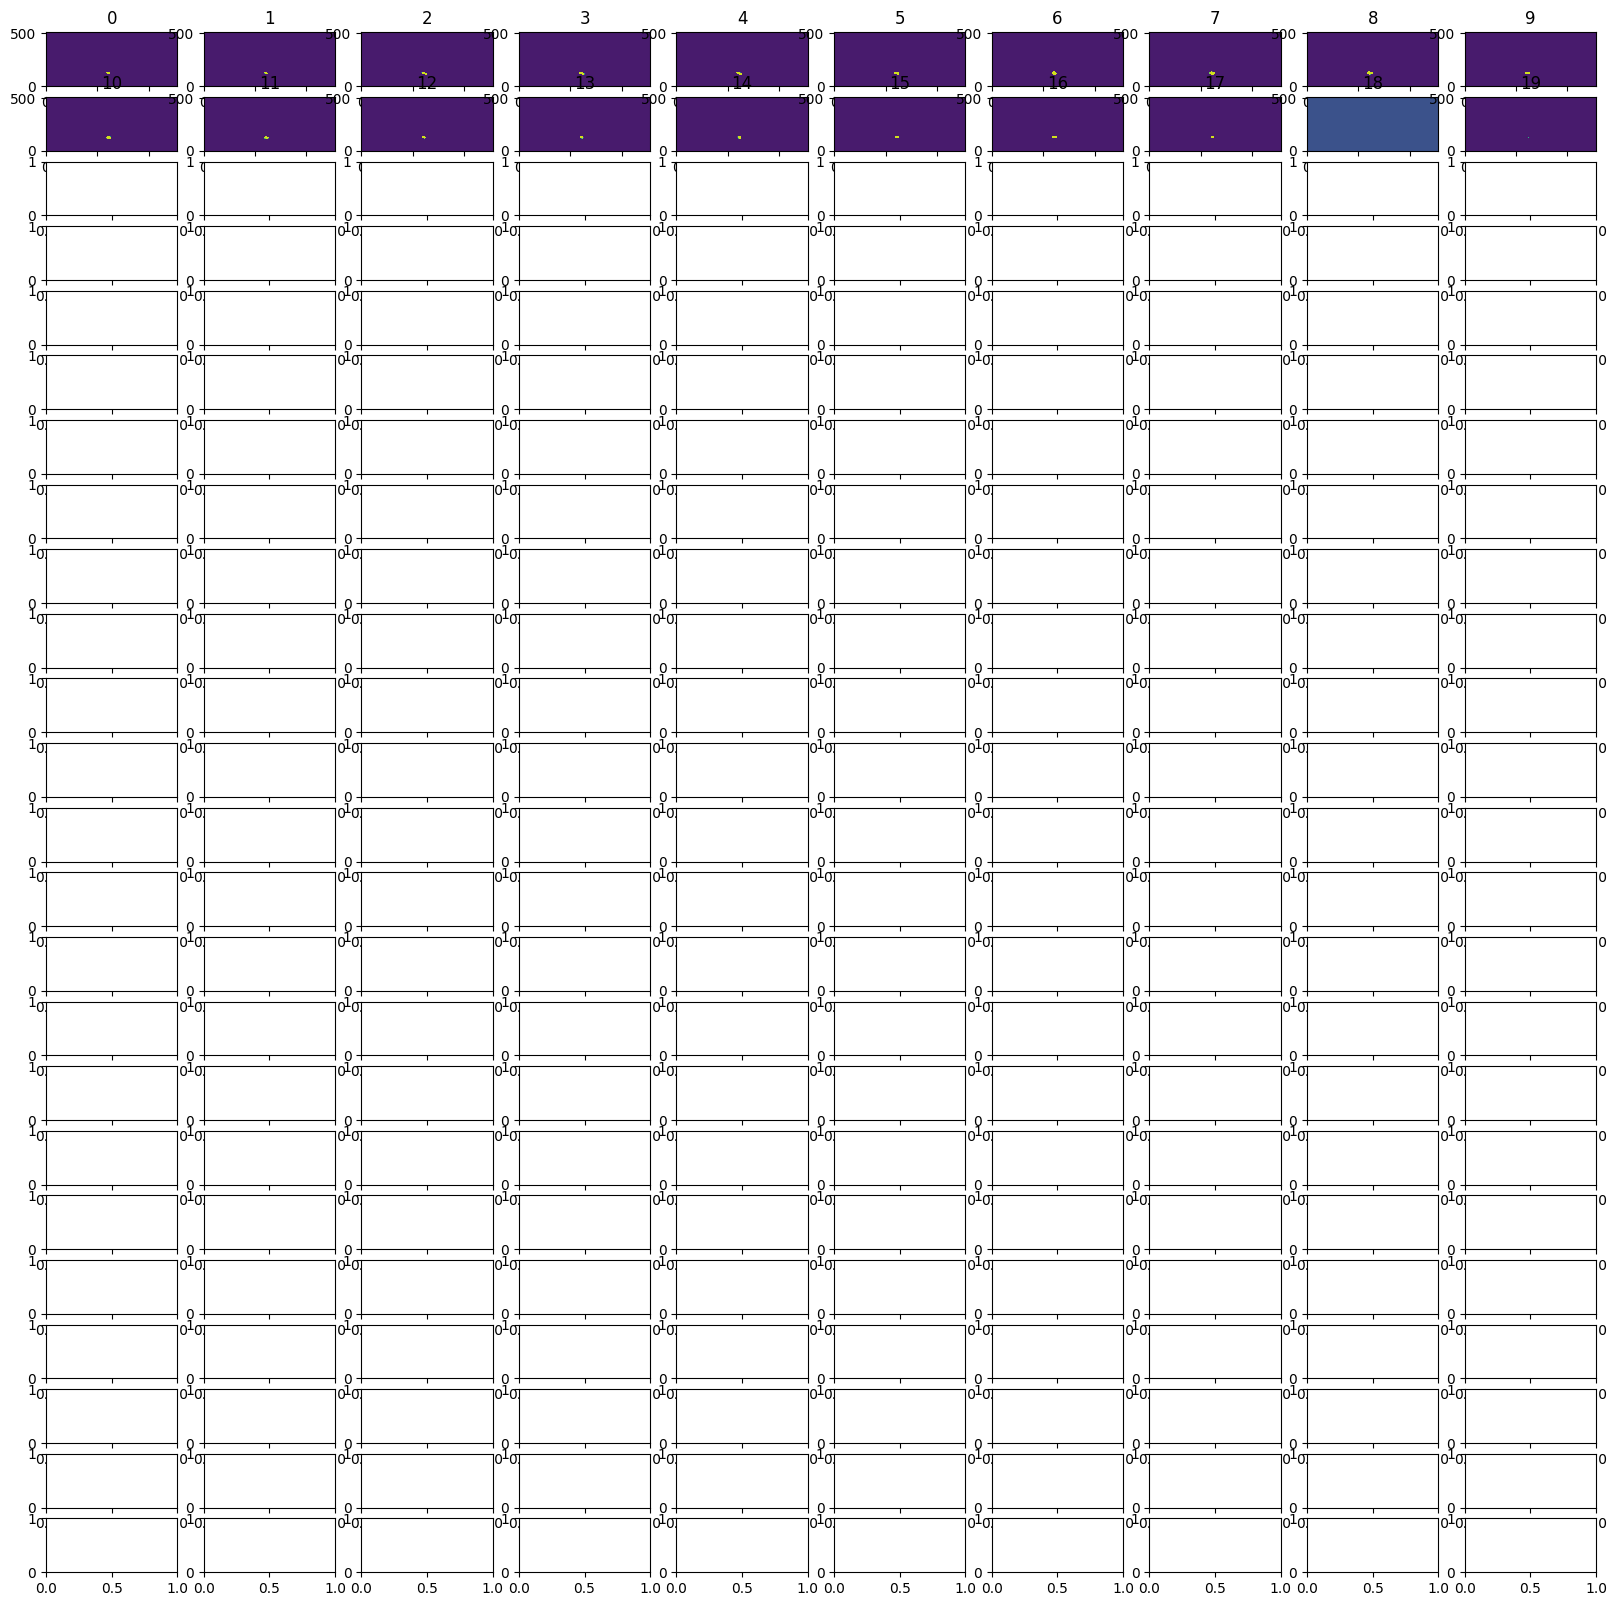

In [98]:
test_load = nib.load("/data4/hrehman/Clinical_Data/Nifti/R01-001/SEG/R01-001_clean.nii").get_fdata()
test_load.shape
fig, axs = plt.subplots(24,10, figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
# plt.imshow(test_load[:,:,141],cmap='gray')
axs = axs.ravel()

for i in range(235):
    # axs[i].contourf(test_load[:,:,i])
    axs[i].contourf(test_load[:,:,i])
    axs[i].set_title(i)

IndexError: index 20 is out of bounds for axis 2 with size 20

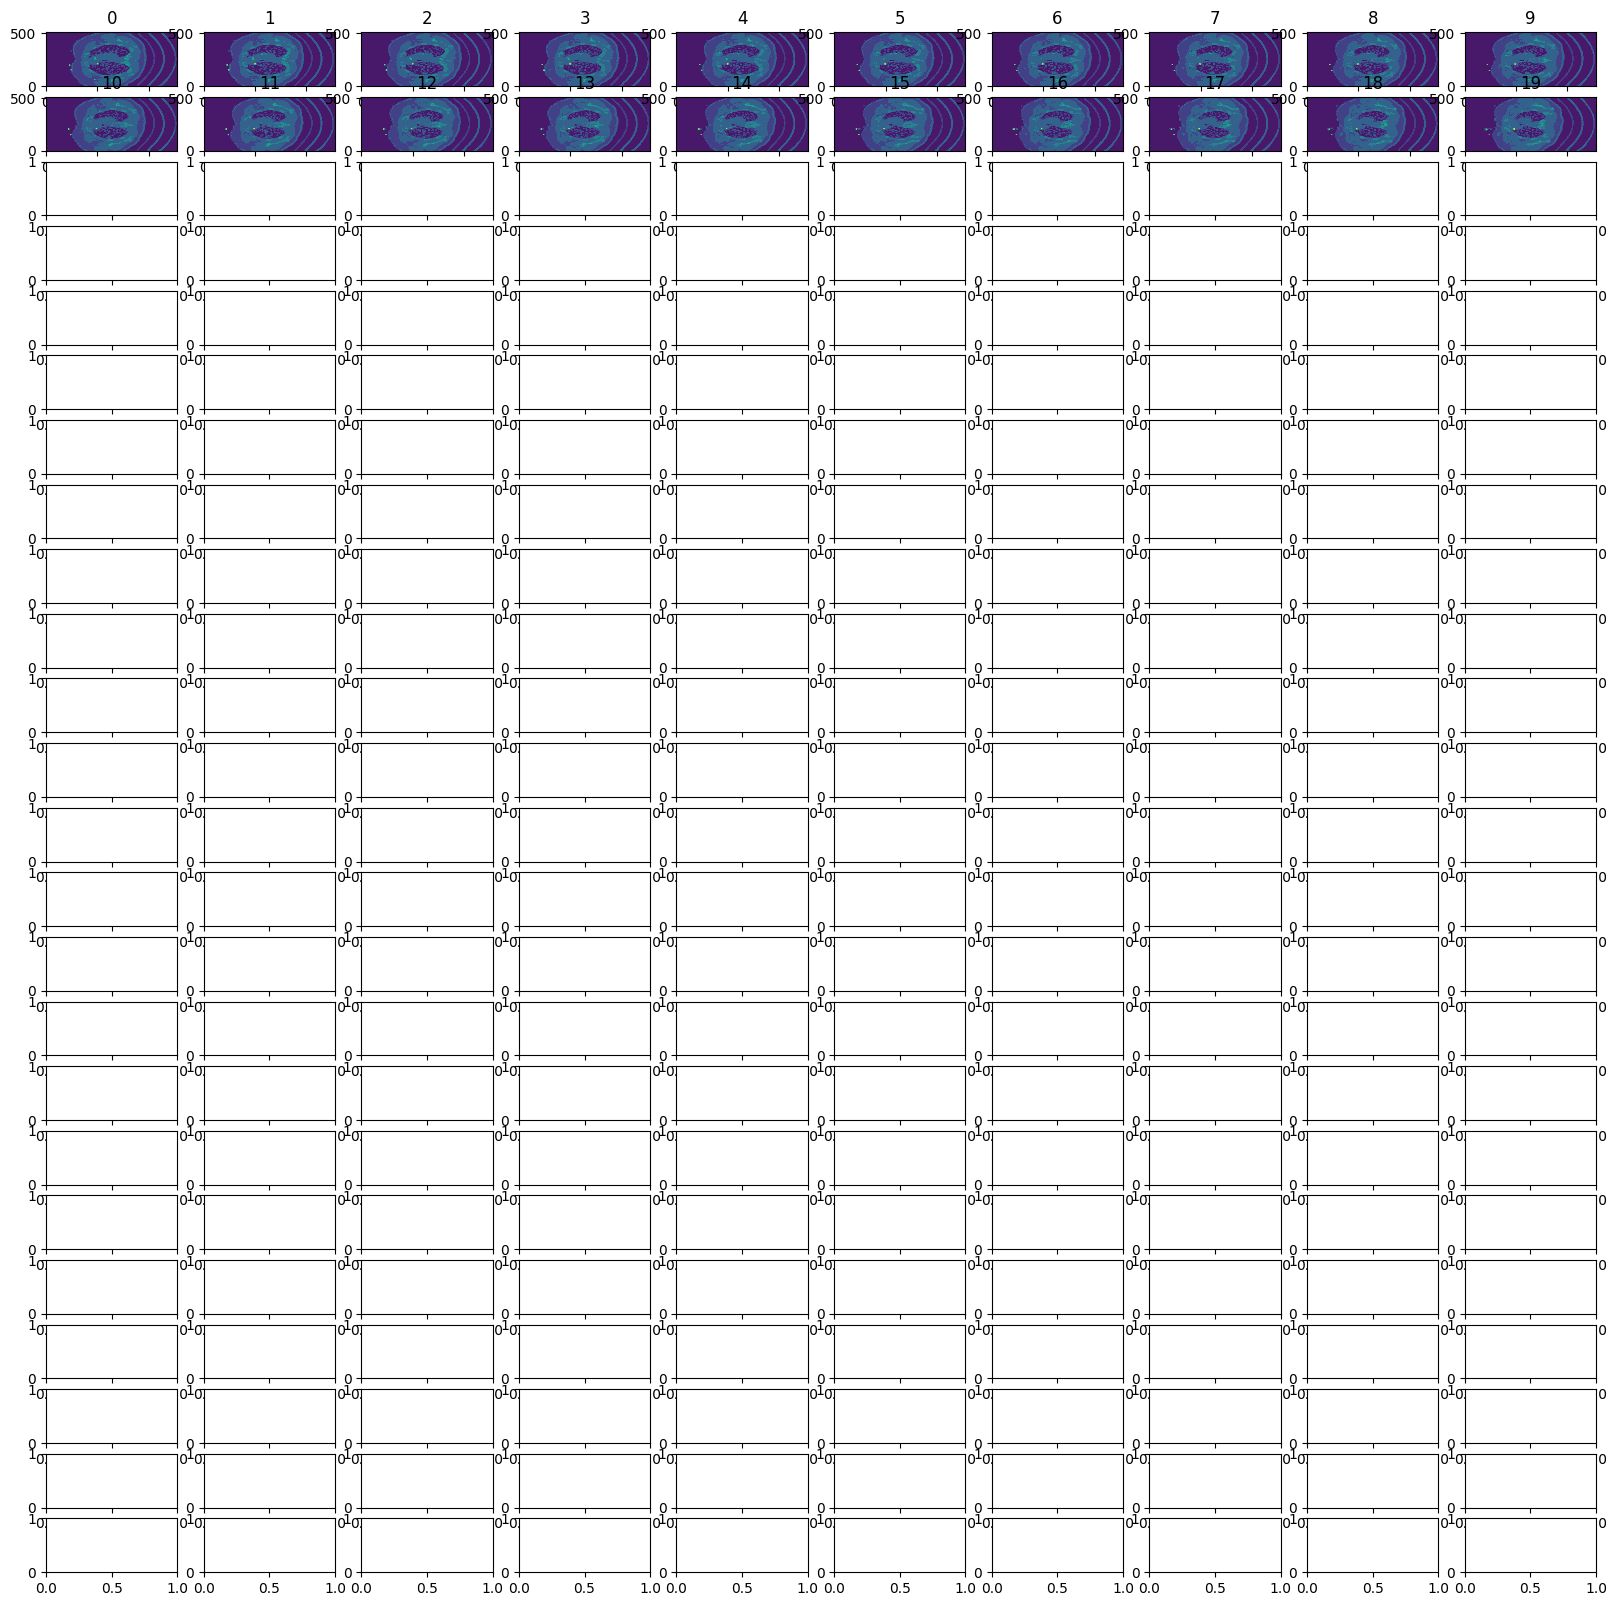

In [99]:
test_load = nib.load("/data4/hrehman/Clinical_Data/Nifti/R01-001/CT/R01-001_clean.nii").get_fdata()
test_load.shape
fig, axs = plt.subplots(24,10, figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
# plt.imshow(test_load[:,:,141],cmap='gray')
axs = axs.ravel()

for i in range(235):
    # axs[i].contourf(test_load[:,:,i])
    axs[i].contourf(test_load[:,:,i])
    axs[i].set_title(i)